# Filtrando ruído com autoencoder convolucional

Nesta aplicação o autocodificador é utilizado como filtro de ruído. 
Utiliza-se o dataset do MNIST, adicionando ruído gaussiano.
A rede é treinada com a entrada com a imagem ruidosa e a saída como a imagem original.

Esta é uma rede totalmente convolucional e para tanto, a rede aceita imagens de entrada de quaisquer dimensões.

O notebook é organizado da seguinte forma:
- importação das bibliotecas
- leitura e tratamento do dataset
- criação da rede
- treinamento da rede
- avaliação da rede com imagens de diversos tamanhos

## Importação das bibliotecas

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

# from os
import os.path

# from torch
import torch
from torch import nn
from torch.autograd import Variable

# from torchvision
import torchvision
from torchvision.datasets import MNIST

# from course libs
import lib.pytorch_trainer as ptt

In [2]:
# verifica se a GPU esta disponivel
use_gpu = torch.cuda.is_available()
print("Usando GPU:", use_gpu)

Usando GPU: True


## Leitura do Dataset

### Carregando dados do MNIST

In [3]:
# diretório dos dados
dataset_dir = '/data/datasets/MNIST/'
processed_folder = 'processed'
training_file = 'training.pt'
test_file = 'test.pt'

# Download dos dados caso não existam
if not (os.path.exists(os.path.join(dataset_dir, processed_folder, training_file)) and
    os.path.exists(os.path.join(dataset_dir, processed_folder, test_file))):
    dataset_train = MNIST(dataset_dir, train=True, download=True)
    del dataset_train

# Carrega dados processados do disco
train_images, _ = torch.load(os.path.join(dataset_dir, processed_folder, training_file))
test_images, _ = torch.load(os.path.join(dataset_dir, processed_folder, test_file))

### Normalizando os dados e criando imagens com ruídos

In [4]:
# Normaliza os dados
train_images = train_images.type(torch.FloatTensor)/255
test_images = test_images.type(torch.FloatTensor)/255

# Cria imagens com ruído
noise_factor = 0.5
train_noisy = train_images + torch.from_numpy(noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_images.shape)).type(torch.FloatTensor)
test_noisy = test_images + torch.from_numpy(noise_factor * np.random.normal(loc=0.0, scale=1.0, size=test_images.shape)).type(torch.FloatTensor)

train_noisy = torch.clamp(train_noisy, 0., 1.)
test_noisy  = torch.clamp(test_noisy, 0., 1.)

# Adciona canal
train_noisy = train_noisy.view(-1, 1, 28, 28)
train_images = train_images.view(-1, 1, 28, 28)
test_noisy = test_noisy.view(-1, 1, 28, 28)
test_images = test_images.view(-1, 1, 28, 28)

print('amostras para treinamento:', len(train_noisy))
print('amostras para validação:',   len(test_noisy))

amostras para treinamento: 60000
amostras para validação: 10000


### Mostrando algumas imagens do conjunto de treinamento

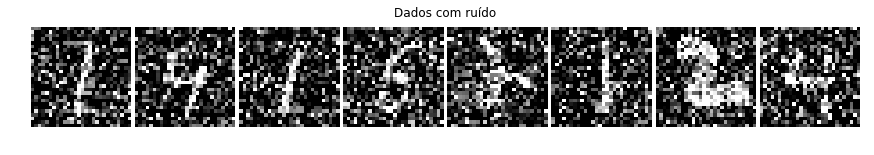

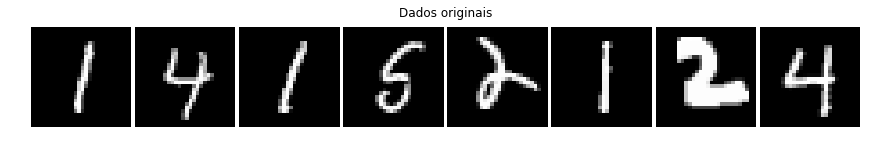

In [5]:
n_samples = 8

# cria um DataLoader temporario para pegar um batch de 'n_samples' imagens de treinamento
temp_train = torch.utils.data.TensorDataset(train_noisy, train_images)
temp_dataloader = torch.utils.data.DataLoader(temp_train,
                                              batch_size = n_samples,
                                              shuffle=True, num_workers=4)

# pega um batch de imagens
noisy_batch, image_batch = next(iter(temp_dataloader))

# cria um grid com as imagens
grid_noisy = torchvision.utils.make_grid(noisy_batch, normalize=True, pad_value=1.0, padding=1)
grid_data = torchvision.utils.make_grid(image_batch, normalize=True, pad_value=1.0, padding=1)

# dados com ruído
plt.figure(figsize=(15, 10))
plt.title("Dados com ruído")
plt.imshow(grid_noisy.numpy().transpose(1, 2, 0))
plt.axis('off')
plt.show()
# dados originais
plt.figure(figsize=(15, 10))
plt.title("Dados originais")
plt.imshow(grid_data.numpy().transpose(1, 2, 0))
plt.axis('off')
plt.show()

del temp_dataloader

### Teste inicial com pouquíssimas amostras

In [6]:
testing = True
if testing:
    n_samples = 800
    train_noisy = train_noisy[:n_samples]
    train_images = train_images[:n_samples]
    
    n_samples_test = 200
    test_noisy = test_noisy[:n_samples_test]
    test_images = test_images[:n_samples_test]

### Criando DataLoader para os dados

In [7]:
batch_size = 64

train = torch.utils.data.TensorDataset(train_noisy, train_images)

train_loader = torch.utils.data.DataLoader(train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=4)

test = torch.utils.data.TensorDataset(test_noisy, test_images)

test_loader = torch.utils.data.DataLoader(test,
                                         batch_size=batch_size,
                                         shuffle=False,
                                         num_workers=4)

## Criação da rede

<img src='../figures/Autoencoder.png', width=1000pt></img>

In [8]:
import torch.nn.functional as F

# classe do AutoEncoder (Encoder + Decoder)
class AutoEncoder(torch.nn.Module):
    def __init__(self, encoder, decoder):
        super(AutoEncoder, self).__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# classe do Encoder
class Encoder(torch.nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
                                                         # entrada: 28x28 | 56x56
        self.encode_conv1 = torch.nn.Conv2d(1, 32, 3, padding=1)  # 28x28 | 56x56
        self.encode_pool1 = torch.nn.MaxPool2d(2, ceil_mode=True)
        self.encode_conv2 = torch.nn.Conv2d(32, 32, 3, padding=1) # 14x14 | 28x28
        self.encode_pool2 = torch.nn.MaxPool2d(2, ceil_mode=True)
                                                                  #   7x7 | 14x14
    def forward(self, x):
        x = F.relu(self.encode_conv1(x))
        x = self.encode_pool1(x)
        x = F.relu(self.encode_conv2(x))
        x = self.encode_pool2(x)
        return x

# classe do Decoder
class Decoder(torch.nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
                                                         # entrada:   7x7 | 14x14
        self.decode_conv1 = torch.nn.Conv2d(32, 32, 3, padding=1) #   7x7 | 14x14
        self.decode_upsa1 = torch.nn.Upsample(scale_factor=2)
        self.decode_conv2 = torch.nn.Conv2d(32, 32, 3, padding=1) # 14x14 | 28x28
        self.decode_upsa2 = torch.nn.Upsample(scale_factor=2)
        self.decode_conv3 = torch.nn.Conv2d(32, 1, 3, padding=1)  # 28x28 | 56x56
        
    def forward(self, x):
        x = F.relu(self.decode_conv1(x))
        x = self.decode_upsa1(x)
        x = F.relu(self.decode_conv2(x))
        x = self.decode_upsa2(x)
        x = F.tanh(self.decode_conv3(x))
        return x

### Rede autoencoder

In [9]:
autoencoder = AutoEncoder(Encoder(), Decoder())
if use_gpu:
    autoencoder = autoencoder.cuda()

### Sumário da rede

Observe que, nesta rede, as dimensões das imagens em todas as camadas podem ser quaisquer, com exceção dos canais (última dimensão) que são 1 na entrada (imagem de cinza) e 1 na saída (imagem de cinza).
Assim, esta rede é dita totalmente convolucional, aceitando portanto imagens de cinza de qualquer tamanho.

In [10]:
print(autoencoder)

AutoEncoder(
  (encoder): Encoder(
    (encode_conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (encode_pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=True)
    (encode_conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (encode_pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=True)
  )
  (decoder): Decoder(
    (decode_conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (decode_upsa1): Upsample(scale_factor=2, mode=nearest)
    (decode_conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (decode_upsa2): Upsample(scale_factor=2, mode=nearest)
    (decode_conv3): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)


## Treinamento

### Criando o objeto de treinamento

In [11]:
optimizer = torch.optim.Adam(autoencoder.parameters())
criterion = nn.MSELoss()
savebest = ptt.ModelCheckpoint('../../models/FiltrandoRuidoAutoencoder',reset=True, verbose=1)

# Cria o objeto para treinar a rede
trainer = ptt.DeepNetTrainer(
    model       = autoencoder,
    criterion   = criterion, 
    optimizer   = optimizer,
    callbacks   = [ptt.PrintCallback(),savebest]
)

In [12]:
train = False
if train:
    trainer.fit_loader(50, train_data=train_loader, valid_data=test_loader)
else:
    trainer.load_state('/data/models/FiltrandoRuidoAutoencoder')

Start training for 50 epochs
  1:   4.0s   T: 0.02203   V: 0.01486 best
  2:   3.9s   T: 0.01428   V: 0.01328 best
  3:   4.2s   T: 0.01319   V: 0.01266 best
  4:   4.2s   T: 0.01263   V: 0.01219 best
  5:   4.2s   T: 0.01228   V: 0.01228 
  6:   4.1s   T: 0.01206   V: 0.01169 best
  7:   3.7s   T: 0.01190   V: 0.01164 best
  8:   4.0s   T: 0.01174   V: 0.01148 best
  9:   4.9s   T: 0.01160   V: 0.01146 best
 10:   4.4s   T: 0.01150   V: 0.01131 best
 11:   3.7s   T: 0.01141   V: 0.01134 
 12:   4.0s   T: 0.01134   V: 0.01142 
 13:   4.4s   T: 0.01128   V: 0.01111 best
 14:   3.9s   T: 0.01122   V: 0.01111 best
 15:   3.5s   T: 0.01118   V: 0.01107 best
 16:   3.5s   T: 0.01115   V: 0.01114 
 17:   3.5s   T: 0.01112   V: 0.01105 best
 18:   3.5s   T: 0.01108   V: 0.01100 best
 19:   3.4s   T: 0.01106   V: 0.01089 best
 20:   3.5s   T: 0.01102   V: 0.01089 best
 21:   4.0s   T: 0.01101   V: 0.01089 best
 22:   3.5s   T: 0.01099   V: 0.01090 
 23:   3.6s   T: 0.01097   V: 0.01088 best
 2

Treinamento em uma GPU Nvidia Geforce 1080Ti:

    Start training for 50 epochs
      1:   4.0s   T: 0.02203   V: 0.01486 best
      2:   3.9s   T: 0.01428   V: 0.01328 best
      3:   4.2s   T: 0.01319   V: 0.01266 best
      4:   4.2s   T: 0.01263   V: 0.01219 best
      5:   4.2s   T: 0.01228   V: 0.01228 
      6:   4.1s   T: 0.01206   V: 0.01169 best
      7:   3.7s   T: 0.01190   V: 0.01164 best
      8:   4.0s   T: 0.01174   V: 0.01148 best
      9:   4.9s   T: 0.01160   V: 0.01146 best
     10:   4.4s   T: 0.01150   V: 0.01131 best
     11:   3.7s   T: 0.01141   V: 0.01134 
     12:   4.0s   T: 0.01134   V: 0.01142 
     13:   4.4s   T: 0.01128   V: 0.01111 best
     14:   3.9s   T: 0.01122   V: 0.01111 best
     15:   3.5s   T: 0.01118   V: 0.01107 best
     16:   3.5s   T: 0.01115   V: 0.01114 
     17:   3.5s   T: 0.01112   V: 0.01105 best
     18:   3.5s   T: 0.01108   V: 0.01100 best
     19:   3.4s   T: 0.01106   V: 0.01089 best
     20:   3.5s   T: 0.01102   V: 0.01089 best
     21:   4.0s   T: 0.01101   V: 0.01089 best
     22:   3.5s   T: 0.01099   V: 0.01090 
     23:   3.6s   T: 0.01097   V: 0.01088 best
     24:   3.6s   T: 0.01095   V: 0.01087 best
     25:   3.9s   T: 0.01093   V: 0.01084 best
     26:   3.6s   T: 0.01091   V: 0.01086 
     27:   3.6s   T: 0.01090   V: 0.01085 
     28:   3.6s   T: 0.01088   V: 0.01080 best
     29:   3.6s   T: 0.01087   V: 0.01077 best
     30:   3.6s   T: 0.01087   V: 0.01121 
     31:   3.8s   T: 0.01084   V: 0.01079 
     32:   3.8s   T: 0.01084   V: 0.01073 best
     33:   3.7s   T: 0.01083   V: 0.01087 
     34:   3.7s   T: 0.01082   V: 0.01074 
     35:   4.2s   T: 0.01082   V: 0.01074 
     36:   3.4s   T: 0.01081   V: 0.01080 
     37:   3.4s   T: 0.01080   V: 0.01075 
     38:   3.5s   T: 0.01077   V: 0.01074 
     39:   3.4s   T: 0.01079   V: 0.01069 best
     40:   3.4s   T: 0.01077   V: 0.01067 best
     41:   3.4s   T: 0.01076   V: 0.01073 
     42:   3.4s   T: 0.01076   V: 0.01102 
     43:   3.4s   T: 0.01075   V: 0.01099 
     44:   3.4s   T: 0.01075   V: 0.01074 
     45:   3.4s   T: 0.01074   V: 0.01066 best
     46:   3.5s   T: 0.01074   V: 0.01067 
     47:   3.5s   T: 0.01072   V: 0.01064 best
     48:   3.4s   T: 0.01072   V: 0.01072 
     49:   3.6s   T: 0.01073   V: 0.01067 
     50:   3.8s   T: 0.01071   V: 0.01068 
    Stop training at epoch: 50/50
    Best model was saved at epoch 47 with loss 0.01064: ../../models/FiltrandoRuidoAutoencoder

## Avaliação

### Testando 8 primeiras amostras de teste

In [13]:
test_hat = trainer.predict_loader(test_loader)

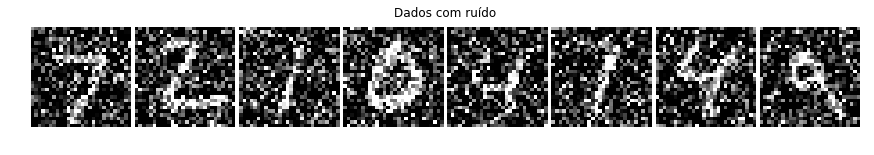

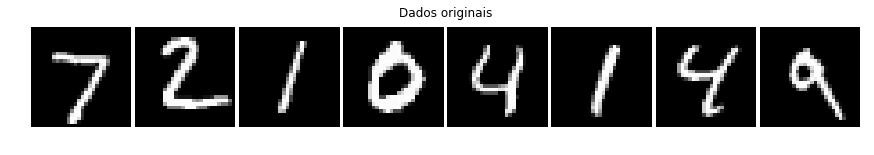

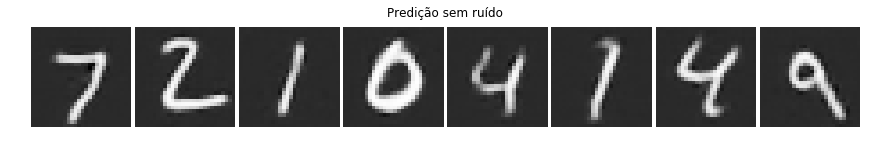

In [14]:
# cria um grid com as imagens
grid_hat = torchvision.utils.make_grid(test_hat[:8], normalize=True, pad_value=1.0, padding=1)
grid_data = torchvision.utils.make_grid(test_noisy[:8], normalize=True, pad_value=1.0, padding=1)
grid_labels = torchvision.utils.make_grid(test_images[:8], normalize=True, pad_value=1.0, padding=1)

# dados com ruído
plt.figure(figsize=(15, 10))
plt.title("Dados com ruído")
plt.imshow(grid_data.numpy().transpose(1, 2, 0))
plt.axis('off')
plt.show()
# dados originais
plt.figure(figsize=(15, 10))
plt.title("Dados originais")
plt.imshow(grid_labels.numpy().transpose(1, 2, 0))
plt.axis('off')
plt.show()
# predição sem ruído
plt.figure(figsize=(15, 10))
plt.title("Predição sem ruído")
plt.imshow(grid_hat.numpy().transpose(1, 2, 0))
plt.axis('off')
plt.show()

### Testando com imagem de tamanho maior

Como a rede é formada de camadas convolucionais, é possível que a imagem de entrada tenha qualquer tamanho.
Veja o exemplo a seguir, onde 4 imagens são juntadas para formar uma de shape=(56,56).

(1, 1, 56, 56)


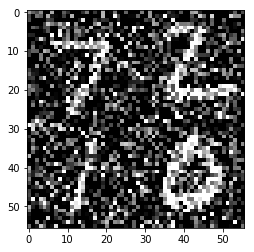

In [15]:
img1 = np.hstack([test_noisy[0].numpy().reshape(28,28),test_noisy[1].numpy().reshape(28,28)])
img2 = np.hstack([test_noisy[2].numpy().reshape(28,28),test_noisy[3].numpy().reshape(28,28)])
img = np.vstack([img1,img2]).reshape(1,1,56,56)
print(img.shape)
plt.imshow(img.reshape(56,56),cmap='gray')
                 

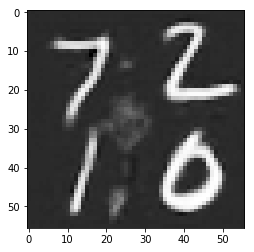

In [16]:
test_hat_large = trainer.predict(torch.Tensor(img))
if use_gpu:
    test_hat_large = test_hat_large.cpu()
plt.imshow(test_hat_large.numpy().reshape(56,56),cmap='gray');

## Exercícios

## Aprendizados